# Classical Method: Random Forest

The objective is to compare the performance of a Random Forest based on extracted features and one based on a tf-idf vectorization of the text field.

In [1]:
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns

In [2]:
import joblib

from collections import Counter
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
base_path = "."

Needed for the feature based approach:

In [4]:
from sklearn.preprocessing import OneHotEncoder

Needed for the text based approach:

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

**Function definitions**

In [6]:
def plot_conf_mat(conf_mat):
    plt.figure()
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, cbar=False, cmap="Accent_r", fmt='g', #annot=True to annotate cells
                vmin=1500, vmax=10000) # To display properly as confusion matrix
    # YlGnBu
    # TN | FP
    #--------
    # FN | TN
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Ham', 'Spam'])
    ax.yaxis.set_ticklabels(['Ham', 'Spam'])


In [7]:
def save_model(model, filename, path="models"):
    models_dir = Path(path)
    joblib.dump(model, models_dir / filename)

# Load full dataset

In [8]:
full_filepath = f"{base_path}/datasets/zenodo_open_metadata_2020-11-14_processed_full.jsonl"
full_df = pd.read_json(full_filepath, lines=True)  # The file is JSONLines
full_df = full_df.set_index('recid')

## Extracted Features RF

In [9]:
full_df.head()

,access_right,spam,num_keywords,num_files,has_image,num_communities,num_creators,creator_has_orcid,creator_has_affiliation,type,type_full,has_license,num_words_title,num_words_description,text_4000,text
recid,,,,,,,,,,,,,,,,
3900603,open,False,0,3,False,1,1,True,True,software,software-None,other,4,100,the geodynamic world builder the geodynamic wo...,the geodynamic world builder the geodynamic wo...
3363990,open,False,6,5,False,0,3,True,True,publication,publication-article,CC-BY-4.0,30,75,alignment ambiguous characters indel maximum l...,alignment ambiguous characters indel maximum l...
3363503,open,False,8,1,True,1,7,False,False,image,image-figure,notspecified,24,75,biodiversity taxonomy animalia arthropoda inse...,biodiversity taxonomy animalia arthropoda inse...
3363619,open,False,8,1,True,1,1,False,False,image,image-figure,notspecified,21,50,biodiversity taxonomy animalia arthropoda maxi...,biodiversity taxonomy animalia arthropoda maxi...
3363729,closed,False,7,0,False,1,3,False,False,publication,publication-article,no-license,14,30,biodiversity taxonomy animalia arthropoda inse...,biodiversity taxonomy animalia arthropoda inse...


In [10]:
ef_df = full_df.drop("text", axis='columns')
ef_df = ef_df.drop("text_4000", axis='columns')

In [11]:
ef_df.dtypes

access_right               object
spam                         bool
num_keywords                int64
num_files                   int64
has_image                    bool
num_communities             int64
num_creators                int64
creator_has_orcid            bool
creator_has_affiliation      bool
type                       object
type_full                  object
has_license                object
num_words_title             int64
num_words_description       int64
dtype: object

In [12]:
for col in ef_df.columns:
    ef_df[col] = ef_df[col].astype('category')
ef_df.dtypes

access_right               category
spam                       category
num_keywords               category
num_files                  category
has_image                  category
num_communities            category
num_creators               category
creator_has_orcid          category
creator_has_affiliation    category
type                       category
type_full                  category
has_license                category
num_words_title            category
num_words_description      category
dtype: object

In [13]:
# Split dataset
labels_ef = list(ef_df['spam'])
data_ef = ef_df.drop("spam", axis='columns')
X_train_ef, X_test_ef, y_train_ef, y_test_ef = train_test_split(data_ef, labels_ef, test_size=0.33, random_state=422)

In [14]:
# Random forest model
pipeline_ef = Pipeline([
    ("ohe", OneHotEncoder()),
    ("clf", RandomForestClassifier(n_estimators=100, n_jobs=4, verbose=True)),
])

# Trains the model. This might take some time (~7min)
feature_clf = pipeline_ef.fit(X_train_ef, y_train_ef)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.2min finished


In [16]:
save_model(feature_clf, '2020_11_14_rf_features.pkl')

In [17]:
y_pred_ef = feature_clf.predict(X_test_ef)
acc = [(ref, pred) for ref, pred in zip(y_test_ef, y_pred_ef)]
c = Counter(acc)
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


Counter({(False, False): 555423, (True, True): 10917, (True, False): 1414, (False, True): 607})
Spam->Spam: 0.8853
Ham -> Ham: 0.9989
Accuracy: 0.9964


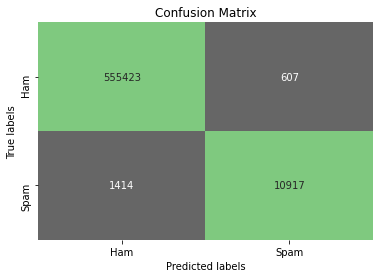

In [18]:
cm_ef = confusion_matrix(y_pred=y_pred_ef, y_true=y_test_ef)
plot_conf_mat(cm_ef)

## Text based RF

In [19]:
full_df.head()

,access_right,spam,num_keywords,num_files,has_image,num_communities,num_creators,creator_has_orcid,creator_has_affiliation,type,type_full,has_license,num_words_title,num_words_description,text_4000,text
recid,,,,,,,,,,,,,,,,
3900603,open,False,0,3,False,1,1,True,True,software,software-None,other,4,100,the geodynamic world builder the geodynamic wo...,the geodynamic world builder the geodynamic wo...
3363990,open,False,6,5,False,0,3,True,True,publication,publication-article,CC-BY-4.0,30,75,alignment ambiguous characters indel maximum l...,alignment ambiguous characters indel maximum l...
3363503,open,False,8,1,True,1,7,False,False,image,image-figure,notspecified,24,75,biodiversity taxonomy animalia arthropoda inse...,biodiversity taxonomy animalia arthropoda inse...
3363619,open,False,8,1,True,1,1,False,False,image,image-figure,notspecified,21,50,biodiversity taxonomy animalia arthropoda maxi...,biodiversity taxonomy animalia arthropoda maxi...
3363729,closed,False,7,0,False,1,3,False,False,publication,publication-article,no-license,14,30,biodiversity taxonomy animalia arthropoda inse...,biodiversity taxonomy animalia arthropoda inse...


### Full text

In [20]:
# Split dataset
labels_tb = full_df['spam']
data_tb = full_df["text"]
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(data_tb, labels_tb, test_size=0.33, random_state=422)

In [21]:
# Random forest model
pipeline_tb = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=8000, ngram_range=(1, 1), analyzer='word', stop_words='english')),
    ("clf", RandomForestClassifier(n_estimators=100, n_jobs=4, verbose=True)),
])

# Trains the model. This might take some time (~45min)
text_clf = pipeline_tb.fit(X_train_tb, y_train_tb)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.5min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 32.9min finished


In [22]:
save_model(text_clf, '2020_11_14_rf_tfidf_text.pkl')

In [23]:
y_pred_tb = text_clf.predict(X_test_tb)
acc = [(ref, pred) for ref, pred in zip(y_test_tb, y_pred_tb)]
c = Counter(acc)
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.6s finished


Counter({(False, False): 555945, (True, True): 11332, (True, False): 999, (False, True): 85})
Spam->Spam: 0.9190
Ham -> Ham: 0.9998
Accuracy: 0.9981


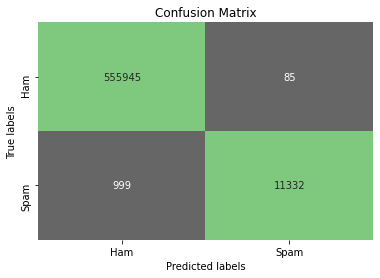

In [24]:
cm_tb = confusion_matrix(y_pred=y_pred_tb, y_true=y_test_tb)
plot_conf_mat(cm_tb)

### Text 4000

In [26]:
# Split dataset
labels_tb4k = full_df['spam']
data_tb4k = full_df["text_4000"]
X_train_tb4k, X_test_tb4k, y_train_tb4k, y_test_tb4k = train_test_split(data_tb4k, labels_tb4k, test_size=0.33, random_state=422)

In [27]:
# Random forest model
pipeline_tb4k = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=8000, ngram_range=(1, 1), analyzer='word', stop_words='english')),
    ("clf", RandomForestClassifier(n_estimators=100, n_jobs=4, verbose=True)),
])

# Trains the model. This might take some time (~30min)
text_clf4k = pipeline_tb4k.fit(X_train_tb4k, y_train_tb4k)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 13.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 31.4min finished


In [28]:
save_model(text_clf4k, '2020_11_14_rf_tfidf_text4k.pkl')

In [29]:
y_pred_tb4k = text_clf4k.predict(X_test_tb4k)
acc = [(ref, pred) for ref, pred in zip(y_test_tb4k, y_pred_tb4k)]
c = Counter(acc)
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   17.0s finished


Counter({(False, False): 555935, (True, True): 11331, (True, False): 1000, (False, True): 95})
Spam->Spam: 0.9189
Ham -> Ham: 0.9998
Accuracy: 0.9981


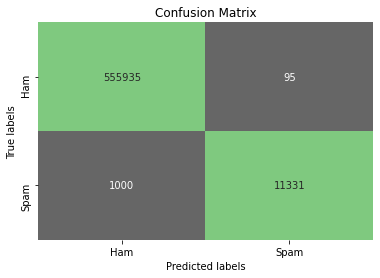

In [30]:
cm_tb4k = confusion_matrix(y_pred=y_pred_tb4k, y_true=y_test_tb4k)
plot_conf_mat(cm_tb4k)

## Check results

In order to verify levels of contamination, check the records that the three models detected as spam but was originally classified as ham.

In [31]:
def get_fp(refs, preds):
    fps = []
    for idx, rec in enumerate(zip(refs, preds)):
        ref, pred = rec[0], rec[1]
        if not ref and pred:
            fps.append(full_df.index[idx])
    return fps

In [32]:
feature_fp = get_fp(y_test_ef, y_pred_ef)
print(f"{len(feature_fp)} false positives with feature extraction.")

text_fp = get_fp(y_test_tb, y_pred_tb)
print(f"{len(text_fp)} false positives with full text vectorization.")

text4k_fp = get_fp(y_test_tb4k, y_pred_tb4k)
print(f"{len(text4k_fp)} false positives with text 4000 vectorization.")

intersect_fp = set(feature_fp).intersection(set(text_fp)).intersection(set(text4k_fp))
print(f"{len(intersect_fp)} false positives are in all sets.""")

607 false positives with feature extraction.
85 false positives with full text vectorization.
95 false positives with text 4000 vectorization.
13 false positives are in all sets.


In [33]:
for recid in intersect_fp:
    print(f"https://zenodo.org/record/{recid}")

https://zenodo.org/record/3515392
https://zenodo.org/record/1000963
https://zenodo.org/record/260003
https://zenodo.org/record/44637
https://zenodo.org/record/3942535
https://zenodo.org/record/196873
https://zenodo.org/record/1310443
https://zenodo.org/record/270895
https://zenodo.org/record/216688
https://zenodo.org/record/3594323
https://zenodo.org/record/3593686
https://zenodo.org/record/235831
https://zenodo.org/record/249469


The previous 13 records were manually checked, they are ham. Therefore the model made a mistake.